In [60]:
# Kullanılacak olan modelin içerisinde bulunduğu script
from Models import myanfis

# Veri işlemeri için kullanılacak olan kütüphane
import pandas as pd

# sayısal işlemler için kullanılan kütüphane
import numpy

# Model için gerekli bir kütüphane
import sys
sys.maxsize

# KFold 
from sklearn.model_selection import KFold

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Model için gerekli olan makine öğrenmesi kütüphanesi
import tensorflow as tf



In [2]:
# veriyi ekledik

df = pd.read_csv("../winequality-red.csv")

In [3]:
# veriye bir bakış attık
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# verideki bütün değerlerin numeric olduğunu gördük
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
# oluşturacağımız model için kullanacağımız feature'lar "volatite acidity" ve "density"
# oluşturacağımız model için target değerlerimiz ise quality'den gelecek
# model için verilerimi 0-1 arasına yerleştirmemiz gerekiyor bunun için MinMaxScaler kullanacağız
minmaxScaler = MinMaxScaler()

# verimizin bir adet kopyasını aldık ki yaptığımız değişiklikler df'i etkilemesin
df2 = df.copy()

# aşağıdaki kısımdaysa verilerimizi 0-1 arasına yerleştiriyoruz
df2['volatile acidity'] = minmaxScaler.fit_transform(df2[['volatile acidity']])
df2['density'] = minmaxScaler.fit_transform(df2[['density']])
df2['quality'] = minmaxScaler.fit_transform(df2[['quality']])

In [50]:
# training ve validation için 2 ye ayırıyoruz
#training
X = df2.iloc[:-199,[1,7]]
Y = df2.iloc[:-199,-1]

# validation, burayı kullanmıyoruz
x = df2.iloc[-199:,[1,7]]
y = df2.iloc[-199:,-1]

In [51]:
# model için gerekli parametre tanımlarını burada "fis_parameters" class'ı ile yapıyoruz
param = myanfis.fis_parameters(
        n_input = 2,                # no. of Regressors
        n_memb = 2,                 # no. of fuzzy memberships
        batch_size = 5,            # 16 / 32 / 64 / ...
        memb_func = 'gaussian',      # 'gaussian' / 'gbellmf' / 'sigmoid'
        optimizer = 'sgd',          # sgd / adam / ...
        loss = tf.keras.losses.MeanAbsoluteError(),               # mse / mae / huber_loss / mean_absolute_percentage_error / ...
        n_epochs = 15               # 10 / 25 / 50 / 100 / ...
        )

In [56]:
# Bu görevde bir supervised yöntem olduğu için KFold = 2 olarak belirledik
kfold = KFold(n_splits=2)
histories = []

# Fold'larımız için gerekli indexleri kfold.split ile alarak X_train, X_test, Y_train, Y_test olarak aldık
# ve Fold Fold eğitimini gerçekleştirdik
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Tensorflow.Keras modellerinden üretilmiş ANFIS'i gerekli parametreler ile çağırdık
    fis = myanfis.ANFIS(n_input = param.n_input,
                    n_memb = param.n_memb,
                    batch_size = param.batch_size,
                    memb_func = param.memb_func,
                    name = 'firstAnfis' # buradaki ismi değiştirin
                    )

    # modelimizi aşağıdaki parametreler ile derledik
    fis.model.compile(optimizer=param.optimizer,
                      loss=param.loss,
                      metrics=['mae']  # ['mae', 'mse']
                      )
    # burada modelimizin eğitimini başlattık
    # daha sonrasında modelin eğitim sonuçlarını history'e atama yaptık 
    history = fis.fit(X_train, Y_train,
                  epochs=param.n_epochs,
                  batch_size=param.batch_size,
                  validation_data = (X_test, Y_test),
                  )
    # model fold fold eğitim yapacağı için eğitim sonuçlarını histories adlı listede tuttuk
    histories.append(history)


Epoch 1/15
140/140 [==============================] - 1s 4ms/step - loss: 0.2606 - mae: 0.2606 - val_loss: 0.2445 - val_mae: 0.2445
Epoch 2/15
140/140 [==============================] - 0s 3ms/step - loss: 0.2148 - mae: 0.2148 - val_loss: 0.2223 - val_mae: 0.2223
Epoch 3/15
140/140 [==============================] - 0s 3ms/step - loss: 0.1877 - mae: 0.1877 - val_loss: 0.2201 - val_mae: 0.2201
Epoch 4/15
140/140 [==============================] - 0s 3ms/step - loss: 0.1757 - mae: 0.1757 - val_loss: 0.2041 - val_mae: 0.2041
Epoch 5/15
140/140 [==============================] - 0s 3ms/step - loss: 0.1679 - mae: 0.1679 - val_loss: 0.2000 - val_mae: 0.2000
Epoch 6/15
140/140 [==============================] - 0s 3ms/step - loss: 0.1603 - mae: 0.1603 - val_loss: 0.1942 - val_mae: 0.1942
Epoch 7/15
140/140 [==============================] - 0s 3ms/step - loss: 0.1549 - mae: 0.1549 - val_loss: 0.1921 - val_mae: 0.1921
Epoch 8/15
140/140 [==============================] - 0s 3ms/step - loss: 0.

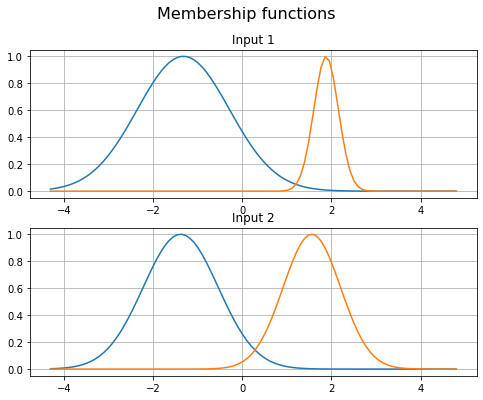

In [65]:
# model eğitiminde elde edilen membership functions grafikleri şekildeki gibidir
fis.plotmfs()

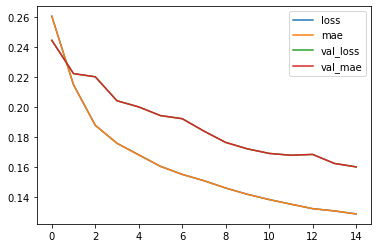

In [58]:
# ilk iterasyonda elde edilen eğitim grafiği aşağıdaki şekilde olduğu gibidir
# İlk fold için konuşacak olursak eğer model iyi bir eğitim yapmadığını söyleyebilirz çünkü val_mae, loss'un üstünde kalmıi
pd.DataFrame(histories[0].history).plot()

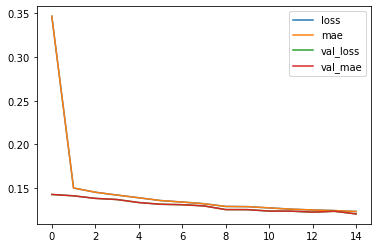

In [59]:
# ikinci iterasyonda elde edilen eğitim grafiği aşağıdaki şekilde olduğu gibidir
# İkinci fold için konuşacak olrusak burada model ilk folda göre oldukça daha başarılı olduğunu söylebiliriz
# çükü val_mae loss çizgisinin altında kalmış durumda

pd.DataFrame(histories[1].history).plot()

In [68]:
# Okuduğunuz için teşekkürler